# SHAP feature selection #
## Code to select feature with combination of LightGBM and SHAP ##

## Parameters cell ##

Parameters are overiddent by papermill when run inside DVC stages



In [1]:
n_folds = 5 # this sets global setting of which how many bootstraps to use
n_hold_out = 0#1
repeats = 10
importance_type = "split"

life_history = ["lifespan"] #, "mass_kg", "mtGC", "metabolic_rate", "temperature", "gestation_days"]
debug_local = True #to use local version

In [2]:
from pathlib import Path
import sys
import inspect

#lgb_params["importance_type"] = importance_type

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

extending pathes with local yspecies
['..', '/data/sources/yspecies/notebooks', '/data/miniconda3/envs/yspecies/lib/python38.zip', '/data/miniconda3/envs/yspecies/lib/python3.8', '/data/miniconda3/envs/yspecies/lib/python3.8/lib-dynload', '', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/IPython/extensions', '/home/anton/.ipython']


In [3]:
from dataclasses import dataclass, replace
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from typing import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.workflow import TupleWith, Repeat, Collect
from yspecies.config import *
from yspecies.preprocess import FeatureSelection, DataExtractor
from yspecies.partition import DataPartitioner, PartitionParameters
from yspecies.models import Metrics

In [5]:
import optuna
from optuna import Study, Trial
from optuna import multi_objective
from optuna.multi_objective import trial
from optuna.multi_objective.study import MultiObjectiveStudy
from yspecies.tuning import MultiObjectiveResults

In [6]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pprint
pp = pprint.PrettyPrinter(indent=4)

#charts settings
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib auto
plt.ioff()
set_matplotlib_formats('svg')

Using matplotlib backend: agg


### Loading data ###
Let's load data from species/genes/expressions selected by select_samples.py notebook

In [7]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")

In [8]:
from loguru import logger
logger.add(locations.logs / "stage_two_shap_selection.log", rotation="12:00")     # New file is created each day at noon

1

In [9]:
stage_2_folder = locations.interim.dir / "stage_2" 
stage_2_folder.mkdir(exist_ok=True)
partitions_folder = stage_2_folder  / "partitions"
partitions_folder.mkdir(exist_ok=True)

In [10]:
data = ExpressionDataset.from_folder(locations.interim.dir / "stage_2" / "input")
data

expressions,genes,species,samples,Genes Metadata,Species Metadata
"(408, 154)","(154, 37)",38,408,"(154, 2)","(38, 18)"


## Setting up features to select ##

In [11]:
default_selection = FeatureSelection(
    samples = ["tissue","species"], #samples metadata to include
    species =  [], #species metadata other then Y label to include
    exclude_from_training = ["species"],  #exclude some fields from LightGBM training
    to_predict = "lifespan", #column to predict
    categorical = ["tissue"],
    select_by = "shap",
    importance_type =  importance_type,
    feature_perturbation = "tree_path_dependent"
)
default_selection

Samples metadata,Species metadata,Genes,Predict label,not_validated species
"['tissue', 'species']",[],all,lifespan,[]


In [12]:
selections = OrderedDict([(trait, (data,  replace(default_selection, to_predict = trait, not_validated_species = data.min_max_trait("lifespan") ))) for trait in life_history])
selections["lifespan"][0]

expressions,genes,species,samples,Genes Metadata,Species Metadata
"(408, 154)","(154, 37)",38,408,"(154, 2)","(38, 18)"


### Setting up pipelines ###

In [13]:
from yspecies.helpers import PipelineFactory
factory = PipelineFactory(locations,repeats, n_folds, n_hold_out)

In [17]:
def opt_by_trait(trait: str, sufix: str = ""):
    return locations.interim.optimization / f"{trait}{sufix}.sqlite"

In [18]:
print("setting up quick pipelines")
quick_pipelines =  {trait:factory.make_shap_pipeline(study_path = opt_by_trait(trait), study_name=f"{trait}_r2_huber_kendall") for trait in life_history}
print("setting up pipelines with repeats")
pipelines = {trait:factory.make_repeated_shap_pipeline(study_path = opt_by_trait(trait), study_name=f"{trait}_r2_huber_kendall") for trait in life_history}
#pipelines = {trait:factory.make_shap_pipeline(trait) for trait in life_history}

#make_partitioning_shap_pipeline
pipelines.keys()

[I 2020-10-12 21:09:08,912] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.


setting up quick pipelines
loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan.sqlite


[I 2020-10-12 21:09:12,077] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.


setting up pipelines with repeats
loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan.sqlite


dict_keys(['lifespan'])

# Run second stage #

In [19]:
stage_two = {}

In [20]:
def run_stage_two(trait: str, quick: bool = False):
    pipes = quick_pipelines if quick else pipelines
    result = pipes[trait].fit_transform(selections[trait])
    stage_two[trait] = result #ugly mutation of stage_one dicionary
    return result

In [22]:
lifespan_2 = run_stage_two("lifespan", False)
lifespan_2.selected

2020-10-12 21:09:55.810 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 0 =====
2020-10-12 21:09:55.812 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-10-12 21:09:55.818 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:10:31.393 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


Early stopping, best iteration is:
[103]	valid_0's l1: 6.08104	valid_0's l2: 99.5004	valid_0's huber: 5.11904
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:11:16.705 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


Early stopping, best iteration is:
[134]	valid_0's l1: 3.32065	valid_0's l2: 44.8228	valid_0's huber: 2.63669
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:12:00.736 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


Early stopping, best iteration is:
[146]	valid_0's l1: 3.05806	valid_0's l2: 28.7155	valid_0's huber: 2.42584
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:12:52.823 | INFO     | yspecies.selection:fit:157 - SEED: 0 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Pan_troglodytes']


Early stopping, best iteration is:
[153]	valid_0's l1: 2.97342	valid_0's l2: 30.3637	valid_0's huber: 2.33117
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[144]	valid_0's l1: 2.80323	valid_0's l2: 31.1593	valid_0's huber: 2.20106


2020-10-12 21:13:50.888 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9364083051173167, MAE=3.647278709150337, MSE=46.91235069601012, huber=2.942293265250515)
2020-10-12 21:13:50.897 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 1 =====
2020-10-12 21:13:50.899 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-10-12 21:13:50.905 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:14:38.316 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Vombatus_ursinus']


Early stopping, best iteration is:
[142]	valid_0's l1: 2.9552	valid_0's l2: 25.0424	valid_0's huber: 2.32663
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:15:18.503 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


Early stopping, best iteration is:
[120]	valid_0's l1: 3.55005	valid_0's l2: 40.9063	valid_0's huber: 2.86028
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:15:45.563 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


Early stopping, best iteration is:
[80]	valid_0's l1: 3.10077	valid_0's l2: 27.9252	valid_0's huber: 2.45401
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:16:46.843 | INFO     | yspecies.selection:fit:157 - SEED: 1 | FOLD: 4 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[185]	valid_0's l1: 4.08239	valid_0's l2: 60.798	valid_0's huber: 3.33658
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[118]	valid_0's l1: 2.87904	valid_0's l2: 24.0873	valid_0's huber: 2.2504


2020-10-12 21:17:46.610 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9496012096635272, MAE=3.313488762679519, MSE=35.75185316347624, huber=2.6470836753544)
2020-10-12 21:17:46.624 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 2 =====
2020-10-12 21:17:46.625 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-10-12 21:17:46.630 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argu

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:18:28.313 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Phascolarctos_cinereus']


Early stopping, best iteration is:
[134]	valid_0's l1: 3.23262	valid_0's l2: 35.2705	valid_0's huber: 2.57172
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:19:22.968 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[169]	valid_0's l1: 3.67499	valid_0's l2: 31.3495	valid_0's huber: 2.96246
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:19:51.804 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


Early stopping, best iteration is:
[86]	valid_0's l1: 3.59848	valid_0's l2: 45.4881	valid_0's huber: 2.89073
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:20:33.068 | INFO     | yspecies.selection:fit:157 - SEED: 2 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Tupaia_belangeri']


Early stopping, best iteration is:
[132]	valid_0's l1: 4.37592	valid_0's l2: 52.5666	valid_0's huber: 3.58382
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[84]	valid_0's l1: 2.49733	valid_0's l2: 22.9855	valid_0's huber: 1.89971


2020-10-12 21:21:17.287 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9425797863977643, MAE=3.475869077297852, MSE=37.53203601345744, huber=2.7811425768143145)
2020-10-12 21:21:17.294 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 3 =====
2020-10-12 21:21:17.295 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-10-12 21:21:17.300 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argume

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:21:47.664 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ursus_americanus', 'Gorilla_gorilla']


Early stopping, best iteration is:
[90]	valid_0's l1: 2.87676	valid_0's l2: 25.7188	valid_0's huber: 2.22713
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:22:15.352 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


Early stopping, best iteration is:
[100]	valid_0's l1: 5.3069	valid_0's l2: 67.0018	valid_0's huber: 4.41966
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:22:48.245 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


Early stopping, best iteration is:
[120]	valid_0's l1: 3.01695	valid_0's l2: 25.3292	valid_0's huber: 2.3568
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:23:24.551 | INFO     | yspecies.selection:fit:157 - SEED: 3 | FOLD: 4 | VALIDATION_SPECIES: ['Suricata_suricatta', 'Meriones_unguiculatus']


Early stopping, best iteration is:
[106]	valid_0's l1: 2.35079	valid_0's l2: 29.8202	valid_0's huber: 1.781
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[110]	valid_0's l1: 2.56609	valid_0's l2: 21.4246	valid_0's huber: 1.95309


2020-10-12 21:24:18.806 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9519467702424178, MAE=3.2234987653703393, MSE=33.8589185880232, huber=2.5423537271763403)
2020-10-12 21:24:18.816 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 4 =====
2020-10-12 21:24:18.818 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-10-12 21:24:18.828 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of ar

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:24:54.388 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ursus_americanus']


Early stopping, best iteration is:
[106]	valid_0's l1: 2.98914	valid_0's l2: 27.6368	valid_0's huber: 2.34256
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:25:36.841 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


Early stopping, best iteration is:
[125]	valid_0's l1: 3.1113	valid_0's l2: 27.955	valid_0's huber: 2.47996
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:26:22.384 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


Early stopping, best iteration is:
[132]	valid_0's l1: 4.48253	valid_0's l2: 51.821	valid_0's huber: 3.70128
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:27:02.214 | INFO     | yspecies.selection:fit:157 - SEED: 4 | FOLD: 4 | VALIDATION_SPECIES: ['Bos_taurus', 'Equus_caballus']


Early stopping, best iteration is:
[157]	valid_0's l1: 5.16685	valid_0's l2: 85.676	valid_0's huber: 4.31306
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[108]	valid_0's l1: 2.19841	valid_0's l2: 18.051	valid_0's huber: 1.6553


2020-10-12 21:27:54.653 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9407764735494502, MAE=3.589646194757685, MSE=42.22795431485292, huber=2.896523088409742)
2020-10-12 21:27:54.661 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 5 =====
2020-10-12 21:27:54.662 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-10-12 21:27:54.668 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead of a

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:28:28.155 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Ovis_aries', 'Heterocephalus_glaber']


Early stopping, best iteration is:
[102]	valid_0's l1: 3.00563	valid_0's l2: 19.6901	valid_0's huber: 2.36265
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:29:10.640 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


Early stopping, best iteration is:
[127]	valid_0's l1: 3.00338	valid_0's l2: 28.9685	valid_0's huber: 2.37179
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:30:12.868 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[185]	valid_0's l1: 5.21131	valid_0's l2: 79.0283	valid_0's huber: 4.34803
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:31:08.641 | INFO     | yspecies.selection:fit:157 - SEED: 5 | FOLD: 4 | VALIDATION_SPECIES: ['Felis_catus', 'Rhinopithecus_bieti']


Early stopping, best iteration is:
[185]	valid_0's l1: 2.97896	valid_0's l2: 34.4628	valid_0's huber: 2.37584
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[102]	valid_0's l1: 2.56293	valid_0's l2: 28.5266	valid_0's huber: 1.98014


2020-10-12 21:31:54.127 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9468834230437357, MAE=3.3524412518089073, MSE=38.13526081120175, huber=2.6828229155650987)
2020-10-12 21:31:54.134 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 6 =====
2020-10-12 21:31:54.135 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-10-12 21:31:54.145 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it 

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:32:44.676 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Suricata_suricatta']


Early stopping, best iteration is:
[155]	valid_0's l1: 3.12626	valid_0's l2: 26.161	valid_0's huber: 2.48025
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:33:48.202 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


Early stopping, best iteration is:
[203]	valid_0's l1: 3.06984	valid_0's l2: 24.772	valid_0's huber: 2.40957
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:34:29.165 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


Early stopping, best iteration is:
[126]	valid_0's l1: 2.82645	valid_0's l2: 28.4718	valid_0's huber: 2.21999
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:35:17.451 | INFO     | yspecies.selection:fit:157 - SEED: 6 | FOLD: 4 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Sus_scrofa']


Early stopping, best iteration is:
[153]	valid_0's l1: 4.55393	valid_0's l2: 51.2719	valid_0's huber: 3.75712
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	valid_0's l1: 2.6302	valid_0's l2: 31.0144	valid_0's huber: 2.05631


2020-10-12 21:36:03.995 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9533212739499334, MAE=3.241334199534112, MSE=32.33821081329256, huber=2.5849705874958686)
2020-10-12 21:36:04.003 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 7 =====
2020-10-12 21:36:04.003 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-10-12 21:36:04.009 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argumen

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:36:39.318 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Capra_hircus']


Early stopping, best iteration is:
[119]	valid_0's l1: 2.81657	valid_0's l2: 32.1899	valid_0's huber: 2.19771
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:37:13.143 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


Early stopping, best iteration is:
[105]	valid_0's l1: 3.07037	valid_0's l2: 36.1585	valid_0's huber: 2.41953
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:38:06.857 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


Early stopping, best iteration is:
[163]	valid_0's l1: 3.07357	valid_0's l2: 27.7963	valid_0's huber: 2.4378
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:38:39.791 | INFO     | yspecies.selection:fit:157 - SEED: 7 | FOLD: 4 | VALIDATION_SPECIES: ['Tupaia_belangeri', 'Ailuropoda_melanoleuca']


Early stopping, best iteration is:
[95]	valid_0's l1: 3.24005	valid_0's l2: 41.2979	valid_0's huber: 2.60878
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[71]	valid_0's l1: 2.41994	valid_0's l2: 16.661	valid_0's huber: 1.85411


2020-10-12 21:39:20.958 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9562722252669926, MAE=2.924098490658722, MSE=30.820710164051455, huber=2.3024662271502025)
2020-10-12 21:39:20.965 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 8 =====
2020-10-12 21:39:20.966 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-10-12 21:39:20.971 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argum

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:39:58.143 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Early stopping, best iteration is:
[112]	valid_0's l1: 2.79514	valid_0's l2: 19.9843	valid_0's huber: 2.17576
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:40:27.536 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


Early stopping, best iteration is:
[94]	valid_0's l1: 3.20705	valid_0's l2: 31.7289	valid_0's huber: 2.55059
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:41:07.713 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


Early stopping, best iteration is:
[144]	valid_0's l1: 3.11565	valid_0's l2: 22.5217	valid_0's huber: 2.49129
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:41:48.904 | INFO     | yspecies.selection:fit:157 - SEED: 8 | FOLD: 4 | VALIDATION_SPECIES: ['Oryctolagus_cuniculus', 'Sus_scrofa']


Early stopping, best iteration is:
[118]	valid_0's l1: 3.00686	valid_0's l2: 53.2422	valid_0's huber: 2.37516
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[112]	valid_0's l1: 2.54952	valid_0's l2: 17.7658	valid_0's huber: 1.9584


2020-10-12 21:42:46.700 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.9575547575239496, MAE=2.934842716153104, MSE=29.04860543729861, huber=2.3070093109512904)
2020-10-12 21:42:46.707 | INFO     | yspecies.selection:fit:153 - ===== fitting models with seed 9 =====
2020-10-12 21:42:46.709 | INFO     | yspecies.selection:fit:154 - PARAMETERS:
{'bagging_fraction': 0.9223944053685549, 'boosting_type': 'gbdt', 'drop_rate': 0.29847846764282016, 'feature_fraction': 0.30501714460224083, 'lambda_l1': 0.21894440516534, 'lambda_l2': 1.3848191603958375, 'learning_rate': 0.08210966706622723, 'max_depth': 3, 'max_leaves': 17, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-10-12 21:42:46.715 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instea

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:43:24.107 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Oryctolagus_cuniculus']


Early stopping, best iteration is:
[108]	valid_0's l1: 3.38132	valid_0's l2: 28.8245	valid_0's huber: 2.71981
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:43:46.988 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


Early stopping, best iteration is:
[63]	valid_0's l1: 5.03864	valid_0's l2: 61.3562	valid_0's huber: 4.18543
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:44:54.918 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


Early stopping, best iteration is:
[203]	valid_0's l1: 3.72012	valid_0's l2: 31.3082	valid_0's huber: 2.99445
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds


2020-10-12 21:45:18.403 | INFO     | yspecies.selection:fit:157 - SEED: 9 | FOLD: 4 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Felis_catus']


Early stopping, best iteration is:
[94]	valid_0's l1: 5.0775	valid_0's l2: 76.8163	valid_0's huber: 4.21375
Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[77]	valid_0's l1: 2.72318	valid_0's l2: 22.2805	valid_0's huber: 2.10653


2020-10-12 21:45:56.512 | INFO     | yspecies.explanations:transform:566 - Metrics: 
Metrics(R2=0.938467650510125, MAE=3.9881508522810103, MSE=44.117157564962795, huber=3.2412687020360176)


,symbol,repeats,mean_shap,mean_kendall_tau,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4,shap_5,kendall_tau_5,shap_6,kendall_tau_6,shap_7,kendall_tau_7,shap_8,kendall_tau_8,shap_9,kendall_tau_9
ENSG00000167515,TRAPPC2L,10.000,13.780,-0.414,12.800,-0.281,12.200,-0.394,15.000,-0.364,11.400,-0.415,13.800,-0.545,18.200,-0.515,14.000,-0.468,13.400,-0.322,10.600,-0.329,16.400,-0.508
ENSG00000165501,LRR1,10.000,12.900,0.702,11.800,0.664,13.200,0.728,12.000,0.741,10.200,0.733,14.000,0.681,15.000,0.754,10.200,0.677,13.000,0.672,15.000,0.691,14.600,0.684
ENSG00000010219,DYRK4,10.000,12.800,0.406,12.000,0.567,12.200,0.316,13.000,0.316,13.200,0.319,11.600,0.583,13.600,0.425,13.600,0.288,13.600,0.363,12.000,0.507,13.200,0.378
ENSG00000204498,NFKBIL1,10.000,12.420,-0.466,14.200,-0.542,14.800,-0.525,13.600,-0.470,11.600,-0.365,12.600,-0.355,10.400,-0.502,11.400,-0.484,13.200,-0.488,11.400,-0.476,11.000,-0.452
ENSG00000211454,AKR7L,10.000,11.980,-0.015,15.600,-0.069,13.400,-0.125,12.600,0.022,8.800,-0.150,12.400,0.272,12.400,-0.201,9.000,0.244,10.400,0.007,13.800,-0.224,11.400,0.073
ENSG00000204231,RXRB,10.000,11.960,-0.602,10.400,-0.734,11.400,-0.536,12.600,-0.527,10.800,-0.678,14.800,-0.704,10.200,-0.603,17.000,-0.567,12.000,-0.597,11.000,-0.641,9.400,-0.429
ENSG00000142002,DPP9,10.000,11.880,-0.756,10.800,-0.745,14.600,-0.727,12.600,-0.774,10.400,-0.768,13.800,-0.734,13.600,-0.759,10.200,-0.786,15.000,-0.796,8.600,-0.745,9.200,-0.728
ENSG00000170835,CEL,10.000,10.940,0.685,14.000,0.708,12.200,0.712,12.400,0.688,11.400,0.727,9.200,0.658,10.000,0.675,8.800,0.672,10.000,0.658,6.800,0.662,14.600,0.687
ENSG00000165555,NOXRED1,10.000,9.540,0.810,10.600,0.758,11.400,0.851,8.400,0.796,8.200,0.825,10.400,0.827,8.000,0.807,10.800,0.793,9.800,0.781,10.600,0.842,7.200,0.825
ENSG00000066923,STAG3,10.000,8.840,0.470,7.800,0.400,9.000,0.511,9.400,0.481,6.400,0.576,6.400,0.357,14.600,0.474,9.600,0.416,7.600,0.428,8.200,0.541,9.400,0.515


## evaluate metrics ###

In [24]:
lifespan_2.metrics_average

Metrics(R2=0.9473811875265212, MAE=3.369064901969159, MSE=37.0743057566627, huber=2.6927934076203788)

In [52]:
#R2=0.9473811875265212, MAE=3.369064901969159, MSE=37.0743057566627, huber=2.6927934076203788)


In [52]:
lifespan_2.validation_metrics["R^2"].mean()

0.9418131680942363

## Check plots ##

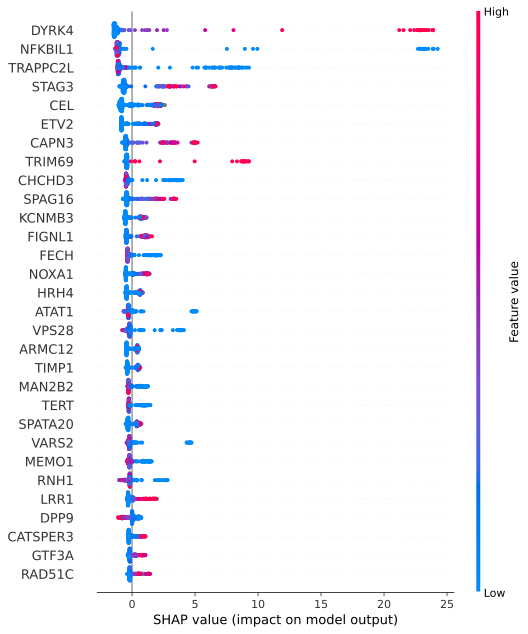

In [25]:
summary_stage_two_plot_path = locations.output.dir / "plots" / "stage_two_summary_lifespan.svg"
lifespan_2.plot(title = "second stage lifespan model", max_display=30, plot_size=0.3, save=summary_stage_two_plot_path )

min_max dataset values: (3.3, 122.5)


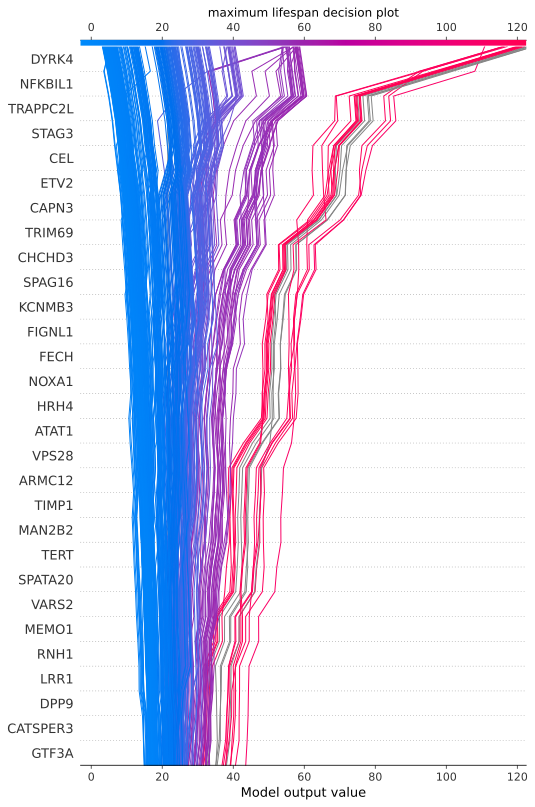

In [26]:
stage_two_decision_plot_path = locations.output.dir / "plots" / "stage_two_decision_lifespan.svg"
lifespan_2.plot_decision(save = stage_two_decision_plot_path , title = "maximum lifespan decision plot", minimum = -3, maximum=120, auto_size_plot=(1000,1000), feature_display_range=slice(-1, -30, -1))

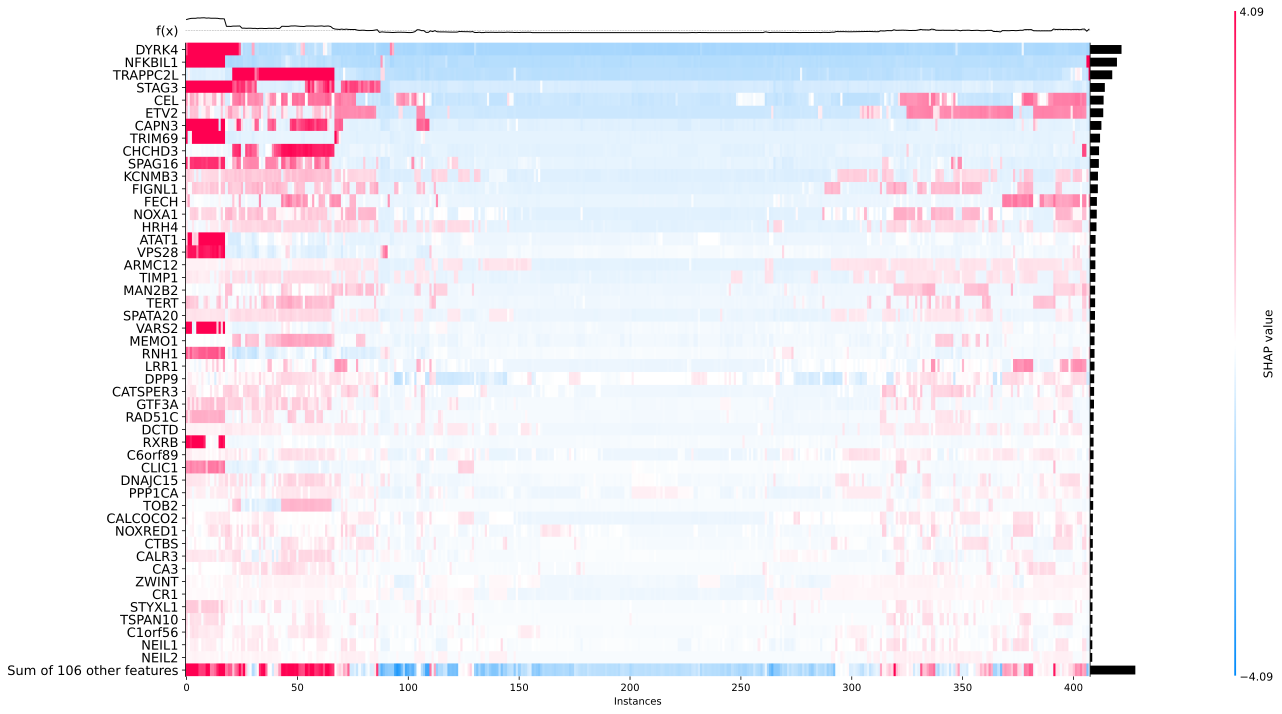

In [48]:
heatmap_stage_two_plot_path = locations.output.plots / "heatmap_lifespan_stage_two.svg"
lifespan_2.plot_heatmap(True, max_display = 50, figsize = (24,12), sort_by_clust=True, save = heatmap_stage_two_plot_path)

### Large pictures ###

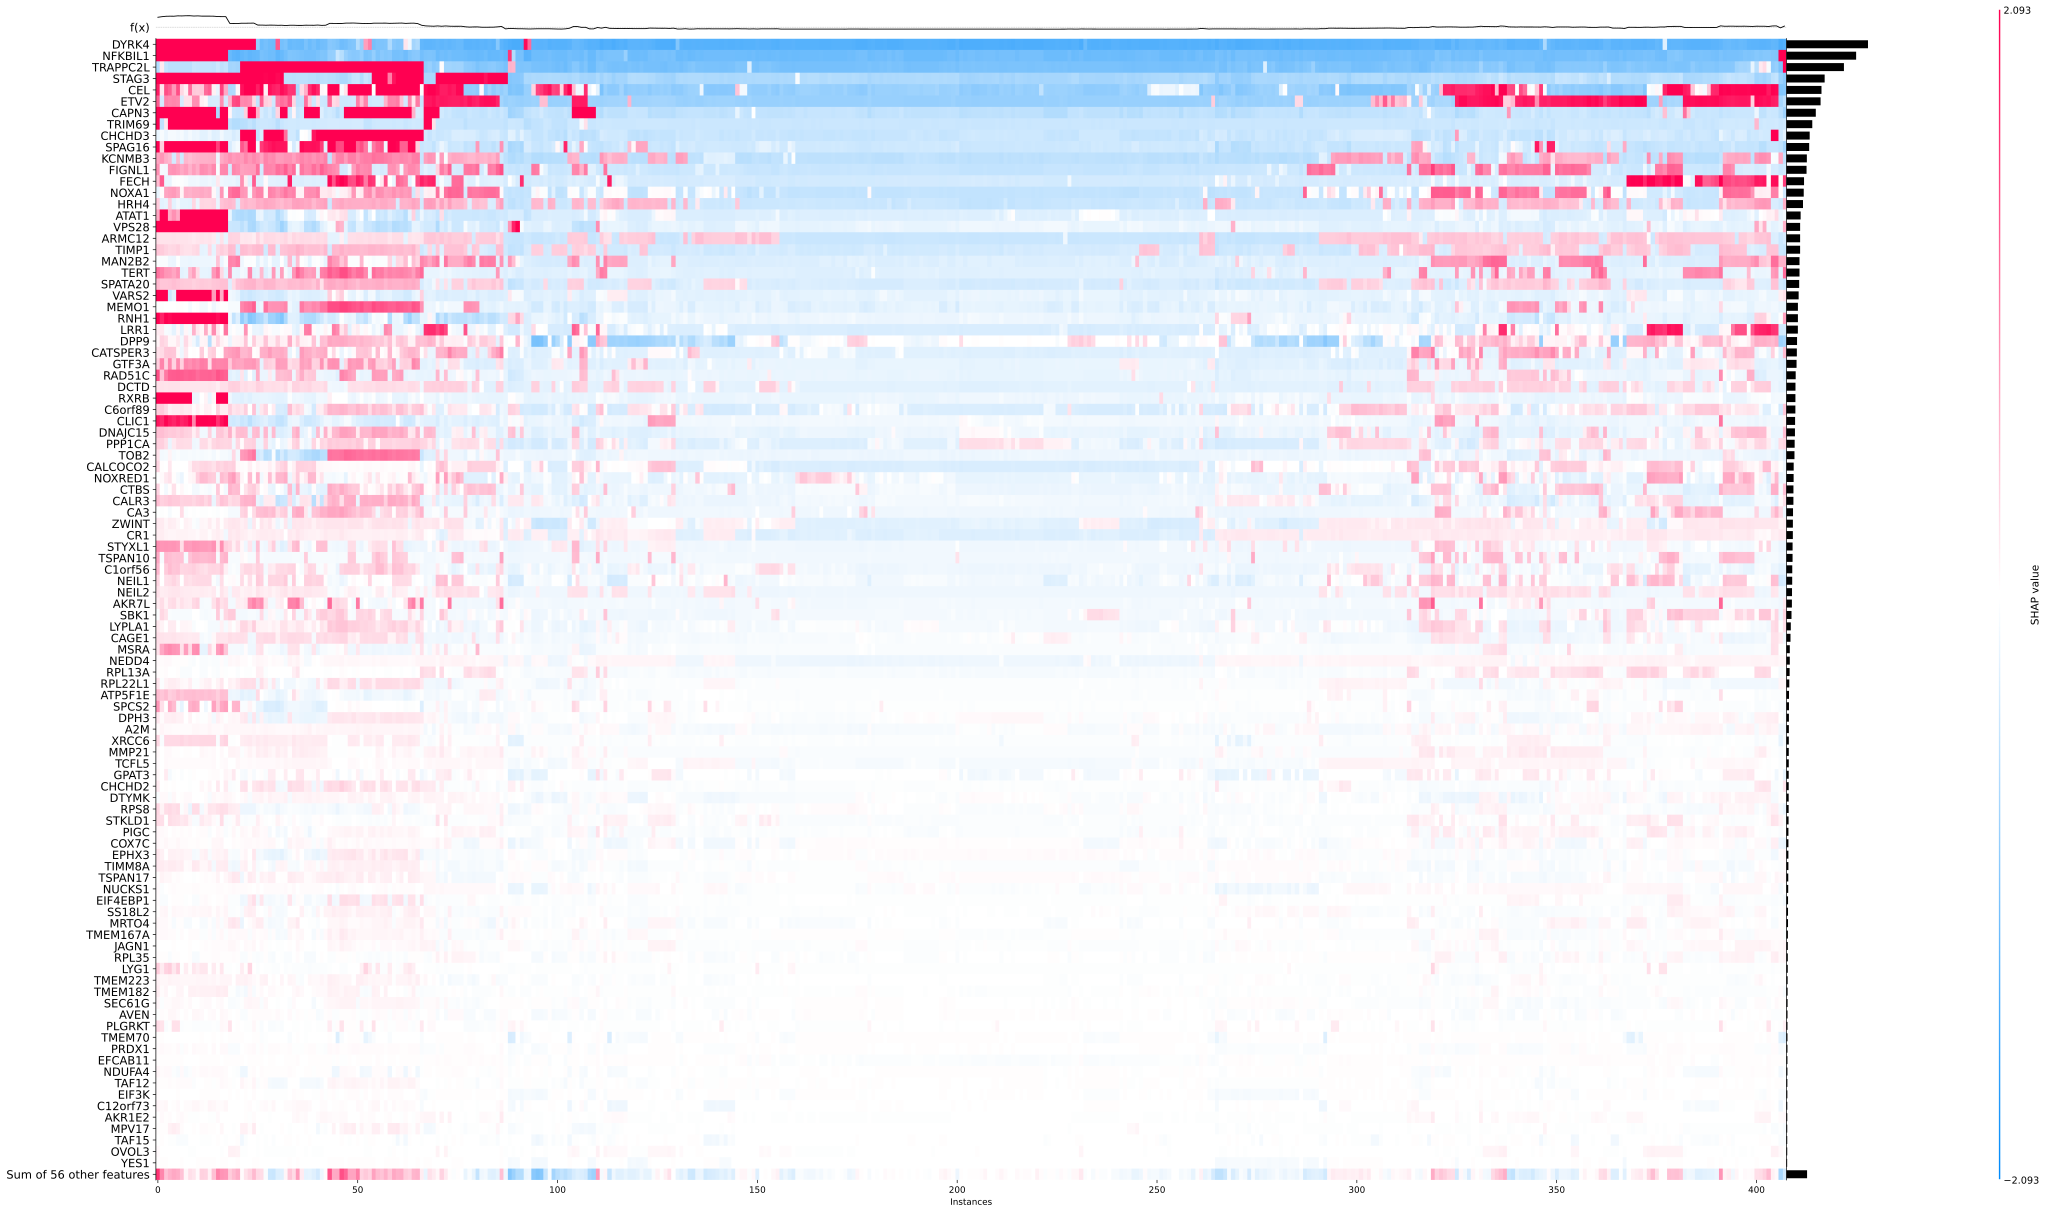

In [49]:
heatmap_stage_two_100_plot_path = locations.output.plots / "heatmap_lifespan_stage_two_100.svg"
lifespan_2.plot_heatmap(True, max_display = 100, figsize = (40,24), sort_by_clust=True, save = heatmap_stage_two_100_plot_path)

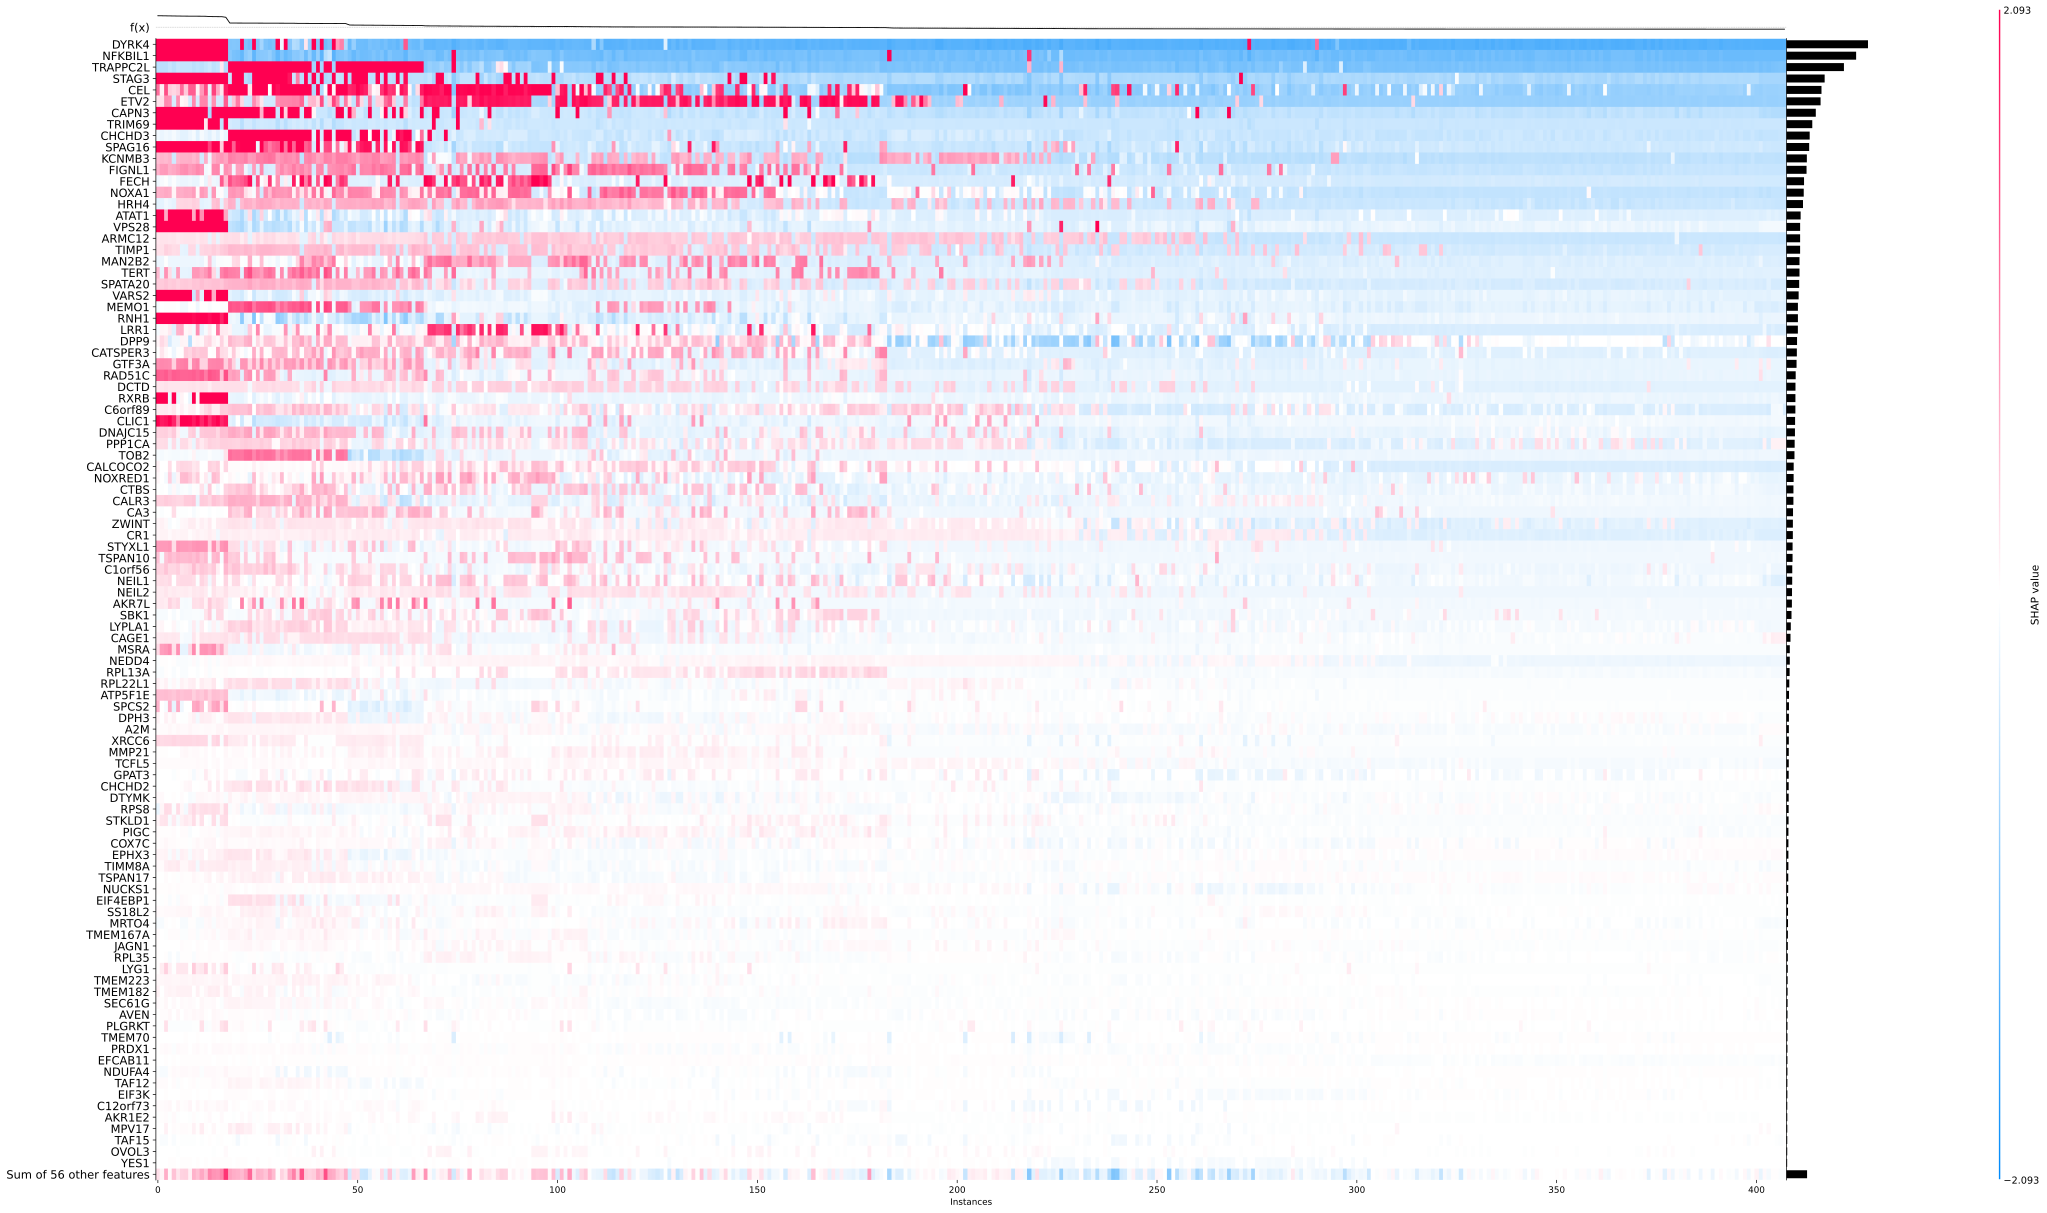

In [46]:
heatmap_stage_two_unclustered_100_plot_path = locations.output.plots / "heatmap_lifespan_stage_two_unclustered_100.svg"
lifespan_2.plot_heatmap(True, max_display = 100, figsize = (40,24), sort_by_clust=False, save = heatmap_stage_two_unclustered_100_plot_path)

## Save files ##

In [29]:
lifespan_2.selected.to_csv(locations.output.stage_two / "lifespan.tsv", sep="\t", index_label="reference_gene")

In [30]:
lifespan_2.write(partitions_folder , "lifespan_stage_two")

PosixPath('../data/interim/stage_2/partitions')

In [31]:
positive = lifespan_2.selected[lifespan_2.selected.mean_kendall_tau > 0.6]
positive_10 = positive[positive.repeats > 9]
positive_10

,symbol,repeats,mean_shap,mean_kendall_tau,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4,shap_5,kendall_tau_5,shap_6,kendall_tau_6,shap_7,kendall_tau_7,shap_8,kendall_tau_8,shap_9,kendall_tau_9
ENSG00000165501,LRR1,10.000,12.900,0.702,11.800,0.664,13.200,0.728,12.000,0.741,10.200,0.733,14.000,0.681,15.000,0.754,10.200,0.677,13.000,0.672,15.000,0.691,14.600,0.684
ENSG00000170835,CEL,10.000,10.940,0.685,14.000,0.708,12.200,0.712,12.400,0.688,11.400,0.727,9.200,0.658,10.000,0.675,8.800,0.672,10.000,0.658,6.800,0.662,14.600,0.687
ENSG00000165555,NOXRED1,10.000,9.540,0.810,10.600,0.758,11.400,0.851,8.400,0.796,8.200,0.825,10.400,0.827,8.000,0.807,10.800,0.793,9.800,0.781,10.600,0.842,7.200,0.825
ENSG00000140398,NEIL1,10.000,7.980,0.771,8.600,0.774,5.400,0.751,9.400,0.756,8.600,0.824,6.600,0.796,9.600,0.773,8.600,0.743,8.800,0.739,6.400,0.780,7.800,0.779
ENSG00000105672,ETV2,10.000,7.640,0.684,7.200,0.718,9.600,0.662,7.000,0.705,5.400,0.691,10.200,0.677,11.800,0.680,3.000,0.649,8.400,0.652,7.400,0.733,6.400,0.670
ENSG00000143443,C1orf56,10.000,7.140,0.680,6.600,0.764,8.400,0.778,5.800,0.448,7.200,0.553,7.400,0.622,9.800,0.762,5.400,0.754,5.800,0.666,9.600,0.726,5.400,0.730
ENSG00000136436,CALCOCO2,10.000,5.980,0.769,7.600,0.769,6.200,0.751,6.600,0.718,5.400,0.811,7.000,0.787,4.800,0.746,6.600,0.747,4.800,0.793,6.200,0.766,4.600,0.795
ENSG00000188747,NOXA1,10.000,5.240,0.673,4.800,0.649,8.000,0.674,5.200,0.668,4.600,0.626,5.200,0.675,5.000,0.700,5.000,0.682,7.000,0.682,3.000,0.675,4.600,0.703


In [32]:
negative = lifespan_2.selected[lifespan_2.selected.mean_kendall_tau < -0.6]
negative_10 = negative[negative.repeats > 9]
negative_10

,symbol,repeats,mean_shap,mean_kendall_tau,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4,shap_5,kendall_tau_5,shap_6,kendall_tau_6,shap_7,kendall_tau_7,shap_8,kendall_tau_8,shap_9,kendall_tau_9
ENSG00000204231,RXRB,10.000,11.960,-0.602,10.400,-0.734,11.400,-0.536,12.600,-0.527,10.800,-0.678,14.800,-0.704,10.200,-0.603,17.000,-0.567,12.000,-0.597,11.000,-0.641,9.400,-0.429
ENSG00000142002,DPP9,10.000,11.880,-0.756,10.800,-0.745,14.600,-0.727,12.600,-0.774,10.400,-0.768,13.800,-0.734,13.600,-0.759,10.200,-0.786,15.000,-0.796,8.600,-0.745,9.200,-0.728
ENSG00000172531,PPP1CA,10.000,8.380,-0.788,9.000,-0.801,8.000,-0.748,8.400,-0.780,9.400,-0.784,8.000,-0.751,10.600,-0.866,7.600,-0.793,7.000,-0.799,9.000,-0.782,6.800,-0.771
ENSG00000137411,VARS2,10.000,7.740,-0.675,9.800,-0.607,8.200,-0.737,8.000,-0.709,8.000,-0.703,8.200,-0.679,6.400,-0.656,9.400,-0.701,6.400,-0.683,6.600,-0.734,6.400,-0.538
ENSG00000117151,CTBS,10.000,5.780,-0.699,6.600,-0.732,5.200,-0.773,6.800,-0.769,3.200,-0.724,8.600,-0.623,6.000,-0.669,5.600,-0.763,6.200,-0.697,3.800,-0.557,5.800,-0.682
ENSG00000120992,LYPLA1,10.000,5.480,-0.637,7.800,-0.607,4.400,-0.683,4.000,-0.697,5.400,-0.619,5.200,-0.621,9.000,-0.673,5.200,-0.680,6.000,-0.550,3.600,-0.563,4.200,-0.680
ENSG00000203710,CR1,10.000,4.700,-0.664,8.400,-0.626,4.400,-0.581,2.600,-0.669,3.800,-0.709,4.800,-0.650,5.000,-0.685,3.800,-0.611,4.600,-0.761,4.000,-0.662,5.600,-0.684


In [33]:
positive_10.index.to_list()

['ENSG00000165501',
 'ENSG00000170835',
 'ENSG00000165555',
 'ENSG00000140398',
 'ENSG00000105672',
 'ENSG00000143443',
 'ENSG00000136436',
 'ENSG00000188747']